# Assignment2 - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [344]:
# student details 1: Nadav Izhaki 329087852
# student details 2: Yossef Okropiridze 208051268

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name: ChatGPT
Goal: Transformation adjustments to improve the model.
Propmpt1:
    Give me different transformation ideas that can help me improve a CNN model based on images of faces dataset. 
Propmpt2:
    Explain the transformations you've suggested.
Propmpt3: 


AI agent name 2: ChatGPT
Goal: To get help with EDA for the project.
Propmpt1:
    How do we show a matrice of some images from the dataset using matplotlib?
Propmpt2:
    How do we represent the number of images we have in train & validation & test datadets using bar plot.
Propmpt3: 

Other assistance:
</pre>

## Part 1(c) - Learning Problem and dataset explaination.

<pre>
Dataset Explanation:
    This dataset contains face images labeled as male or female. 
    It includes 1747 male and 1747 female images for training, and 100 male + 100 female images for both testing and validation. 
    The training and test are balanced, each containing roughly 50% male and 50% female images.
    All images were automatically cropped to show only the face using a tool called MTCNN.

I’m using this dataset to train a CNN (Convolutional Neural Network) model, 
which includes convolutional layers for feature extraction and fully connected layers at the end for decision making. 
The model will be used for binary classification to recognize whether a face image is male (1) or female (0).


Link to dataset: https://www.kaggle.com/datasets/gpiosenka/gender-classification-from-an-image

Note: You need to download the folder named gender_rev2 and then rename its folder to data.
</pre>

## Part 2 - Initial Preparations 

In [345]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm  

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import functional as F

In [346]:
# Check if torch is installed
print(f"Using torch version {torch.__version__}")

# Set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device") 

Using torch version 2.5.1+cu121
Using cuda device


In [347]:
# Start Hyperparameters
CLASS_NAMES = ["female", "male"]

RANDOM_SEED = 42  # Seed for reproducibility

BATCH_SIZE = 64
EPOCHS = 11
HIDDEN_UNITS = 64  # Number of filters in the convolutional layers
KERNEL_SIZE = 3  # Size of the convolutional filters (3x3)
STEP_SIZE = 1  # Stride of the convolutional filters (1 pixel step)
POOL_KERNEL_SIZE = 2  # Size of the max pooling window (2x2)

LERRNING_RATE = 0.001  # Learning rate for the optimizer

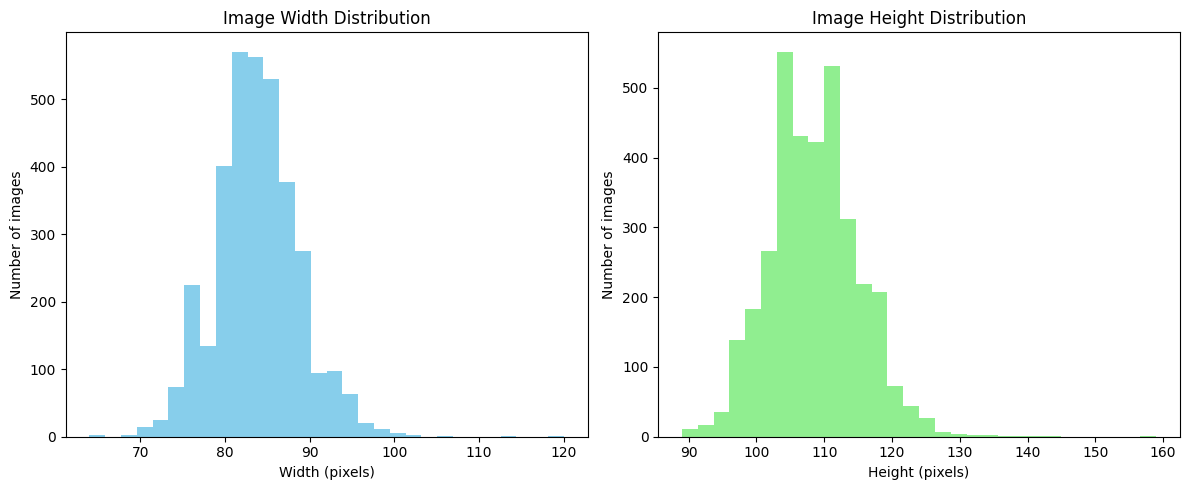

In [348]:
# Function to plot the distribution of image sizes in a directory

def plot_image_size_distribution(root_dir):
    widths = []
    heights = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.jpg')):
                path = os.path.join(subdir, file)
                try:
                    img = Image.open(path)
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
                except Exception as e:
                    print(f"Error loading {path}: {e}")


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=30, color='skyblue')
    plt.title('Image Width Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Number of images')

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=30, color='lightgreen')
    plt.title('Image Height Distribution')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Number of images')

    plt.tight_layout()
    plt.show()


plot_image_size_distribution('data/train')

Transformations:

1. Padding:
Based on the image size distribution, we chose 100×128 pixels.
The function resizes each image to fit within this box without distortion, leaving smaller images unchanged, then pads them evenly with black borders to reach the exact size.

2. ColorJitter:
Randomly changes the colors in the image to help it learn better:
brightness = 0.2 -> randomly change the brightness in a range between ±20%.
contrast = 0.2 -> changes the contrast in a range between ±20%.
saturation = 0.2 -> changes the saturation in a range between ±20%.
hue = 0.1 -> moves the color shade in a range between ±10%

3. GaussianBlur:
Use a "Gaussian filter", which is a mathematical way to make a gentle blur.
kernel_size = (3,3) 3x3 pixels - this means the size of the filter which commits the blur is small.
sigma = (0.1, 2.0) each time the transmormation happens, it will randomly pick a value between 0.1(almost no blur) and 2.0 (more intense blur) - this means, how intense will the blur be.

* ColorJitter and GaussianBlur are transformations we use only on the train dataset.

Why do we use ColorJitter and GaussianBlur:
The purpose of these transformations is Data Augmentation - meaning we "teach" the model how to handle with stranger images so it will be more resilient to these types of changes, that's why we only use these transformations on the train dataset.
When we run on the test / validation datasets, we don't use these transformations because we want to assess the model's real capabilities. 

In [349]:
def pad_to_100x128(img):
    # Resize to fit inside 100x128, keep aspect ratio
    img.thumbnail((100, 128))  # modifies img in-place

    # Get new size
    w, h = img.size

    # Compute padding amounts (left, top, right, bottom)
    pad_left = (100 - w) // 2
    pad_top = (128 - h) // 2
    pad_right = 100 - w - pad_left
    pad_bottom = 128 - h - pad_top

    # Pad the image
    return F.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=0)


transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)), 
    transforms.Lambda(pad_to_100x128),
    transforms.ToTensor()
])

transform_all = transforms.Compose([
    transforms.Lambda(pad_to_100x128),
    transforms.ToTensor()
])

In [350]:
# Load datasets
train_dataset = datasets.ImageFolder(root='data/train', transform=transform_train)
val_dataset   = datasets.ImageFolder(root='data/valid', transform=transform_all)
test_dataset  = datasets.ImageFolder(root='data/test', transform=transform_all)

print(f"Label map of datset: {train_dataset.class_to_idx}")


Label map of datset: {'female': 0, 'male': 1}


In [351]:
# Create DataLoaders
torch.manual_seed(RANDOM_SEED)  # Set random seed for reproducibility
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nLength of Train dataloader: {len(train_loader)}, batches of {BATCH_SIZE}.")
print(f"Length of validation dataloader: {len(val_loader)}, batches of {BATCH_SIZE}.")
print(f"Length of Test dataloader: {len(test_loader)}, batches of {BATCH_SIZE}.")
print("The dataset is balanced with approximately 50% of images from each class (male and female).")


Length of Train dataloader: 55, batches of 64.
Length of validation dataloader: 4, batches of 64.
Length of Test dataloader: 4, batches of 64.
The dataset is balanced with approximately 50% of images from each class (male and female).


In [352]:
"""
Simple CNN model with 3 convolutional layers for feature extraction 
and 2 fully connected layer for binary classification (e.g., male vs female).
"""
class GenderClassifier(nn.Module):
    def __init__(self, hidden_units: int, kernel_size: int, step_size: int, pool_kernel_size: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,  # Number of input channels, 3 for RGB images.
                      out_channels=hidden_units,  # Number of filters (feature maps) the layer will produce. ("num neurons")
                      kernel_size=kernel_size,  # Size of each filter (e.g., 3 means 3×3 kernels).
                      stride=step_size,  # How many pixels the filter moves at each step (1 = move one pixel at a time)
                      padding=0   # No padding here since images were already padded during dataset preparation to fit 100×128.
            ),  
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=pool_kernel_size)  # Window size, Take only the max vaue from each window step    
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units, 
                      kernel_size=kernel_size, 
                      stride=step_size,  
                      padding=1
            ),  
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=pool_kernel_size)    
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units, 
                      kernel_size=kernel_size, 
                      stride=step_size,  
                      padding=1  
            ),  
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=pool_kernel_size)    
        )

        self.fully_connected_1 = nn.Sequential(
            nn.Flatten(),  # Flatten the output from the convolutional layers to feed into the fully connected layer
            nn.Linear(in_features=12*15*hidden_units,  # Number of input features, calculated 2 boxes in ahead
                      out_features=hidden_units // 2),  
            nn.ReLU()  
        )

        self.fully_connected_2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units // 2, 
                      out_features=1  # Binary classification
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the model."""
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.fully_connected_1(x)
        x = self.fully_connected_2(x)
        return x
    

    def test_conv_layers(self, x: torch.Tensor) -> torch.Tensor:
        """Test the convolutional layers only."""
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        return x

In [353]:
# Create model instance
torch.manual_seed(RANDOM_SEED)
model = GenderClassifier(hidden_units=HIDDEN_UNITS,
                        kernel_size=KERNEL_SIZE,
                        step_size=STEP_SIZE,
                        pool_kernel_size=POOL_KERNEL_SIZE).to(device)

## Part 3 - Experiments
You could add as many code cells as needed

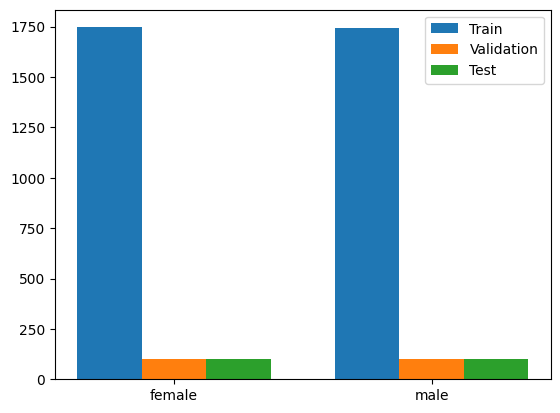

In [354]:
"""
Display the total number of samples from each dataset to get an overview of they sizes.
"""
from collections import Counter

# Count images per class in each dataset
train_counts = Counter([label for _, label in train_dataset])
val_counts = Counter([label for _, label in val_dataset])
test_counts = Counter([label for _, label in test_dataset])

classes = train_dataset.classes
x = range(len(classes))
width = 0.25  # width of each bar

# Plot bars for train, val, and test counts side by side
plt.bar([i - width for i in x], [train_counts[i] for i in x], width, label='Train')
plt.bar(x, [val_counts[i] for i in x], width, label='Validation')
plt.bar([i + width for i in x], [test_counts[i] for i in x], width, label='Test')

plt.xticks(x, classes)  # Label x-axis with class names
plt.legend()
plt.show()


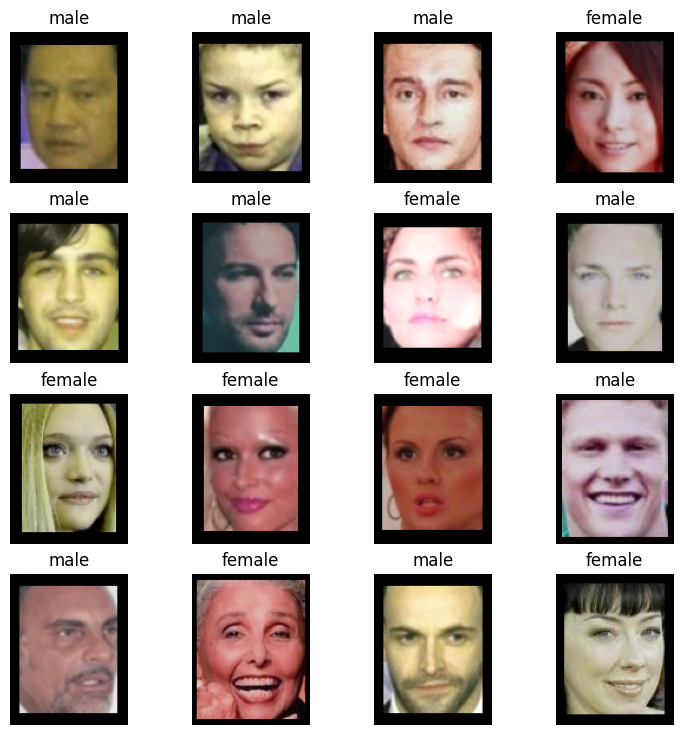

In [355]:
"""
Visualize example images from the train dataset along with their labels to get a clear idea of what 
the data looks like and confirm the labels match the images.
"""
def plot_images_examples(datset, class_names):
    torch.manual_seed(RANDOM_SEED)
    fig = plt.figure(figsize=(9,9))
    rows, cols = 4, 4

    for i in range(1, rows*cols + 1):
        random_idx = torch.randint(0, len(datset), size=[1]).item()
        img, label = datset[random_idx]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.title(class_names[label])
        plt.axis(False)

    plt.show()


plot_images_examples(datset=train_dataset, class_names=CLASS_NAMES)

In [364]:
# Check output from conv layers
torch.manual_seed(RANDOM_SEED)
sample_input = torch.randn(10, 3, 100, 128).to(device)  # Random input tensor with shape (batch_size=10, channels=3, height=100, width=128)

output = model.test_conv_layers(sample_input)  
print(f"Sample output shape: {output.shape}")

"""
Output shape: torch.Size([batch_size, hidden_units , 12, 15]) wich means each image is reduced
to 12X15 feature maps after the convolutional layers.
from this we know the size of the input to the first fully connected layer is 15*12*hidden_units
"""

# Checks outputs from the models, to understand output shapes
model.eval()
with torch.inference_mode():
    logits = model(sample_input)
    print(f"Logits shape: {logits.shape}")

    logits = logits.squeeze(dim=1)  
    print(f"Convert logits to one dim (row): {logits}")

    probs = torch.sigmoid(logits)
    pred_labels = torch.round(probs)
    print(f"Probs (after sigmoid): {probs}")
    print(f"Pred label: {pred_labels}")

    print(logits.dtype)  # Should be torch.float


Sample output shape: torch.Size([10, 64, 12, 15])
Logits shape: torch.Size([10, 1])
Convert logits to one dim (row): tensor([ 0.7563,  4.6285, -2.3491,  5.1874,  3.3986,  4.4368,  2.2919,  1.6213,
         0.4061,  3.8167], device='cuda:0')
Probs (after sigmoid): tensor([0.6806, 0.9903, 0.0871, 0.9944, 0.9677, 0.9883, 0.9082, 0.8350, 0.6002,
        0.9785], device='cuda:0')
Pred label: tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
torch.float32


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [357]:
# Binary Cross Entropy with Logits Loss For binary classification
loss_fn = nn.BCEWithLogitsLoss()

# Function to calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true,  y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

# Adam optimizer for training the model
#optimizer = torch.optim.SGD(params=model.parameters(), lr=LERRNING_RATE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LERRNING_RATE)

In [358]:
# Training loop
def train():
    model.train()
    total_loss, total_acc = 0, 0

    for batch, labels in tqdm(train_loader):
        # Move data to device
        labels = labels.to(device)
        batch = batch.to(device)

        # Forward pass
        logits = model(batch)
        logits = logits.squeeze(dim=1) # Remove first dim. from [[x],[x],...] to [x,x,...]
        loss = loss_fn(logits, labels.float())
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        y_pred = torch.round(torch.sigmoid(logits))
        acc = accuracy_fn(y_true=labels, y_pred=y_pred)
        total_acc += acc

    # Retuen mean loss and accuracy per batch
    return total_loss / len(train_loader), total_acc / len(train_loader)

# Validation Loop
def evaluate():
    model.eval()
    total_loss, total_acc = 0.0, 0.0

    with torch.inference_mode():
        for batch, labels in tqdm(val_loader):
            # Move data to device
            labels = labels.to(device)
            batch = batch.to(device)

            # Forward pass
            logits = model(batch)
            logits = logits.squeeze(dim=1)
            loss = loss_fn(logits, labels.float())
            total_loss += loss.item()

            # Calculate accuracy
            y_pred = torch.round(torch.sigmoid(logits))
            acc = accuracy_fn(y_true=labels, y_pred=y_pred)
            total_acc += acc

    # Retuen mean loss and accuracy per batch
    return total_loss / len(val_loader), total_acc / len(val_loader)

"""
train_loss, train_acc = train()
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")
"""

'\ntrain_loss, train_acc = train()\nprint(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")\n'

In [359]:
# Save train and accuracy of train and eval for visualization
train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")

    print("training...")
    train_loss, train_acc = train()

    print("evaluating...")
    val_loss, val_acc = evaluate()

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)



Epoch 0
training...


100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


evaluating...


100%|██████████| 4/4 [00:00<00:00, 16.66it/s]


Train Loss: 0.6043, Train Accuracy: 65.76%
Val Loss: 0.4813, Val Accuracy: 78.52%

Epoch 1
training...


100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


evaluating...


100%|██████████| 4/4 [00:00<00:00, 17.38it/s]


Train Loss: 0.4163, Train Accuracy: 81.41%
Val Loss: 0.3261, Val Accuracy: 87.11%

Epoch 2
training...


100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


evaluating...


100%|██████████| 4/4 [00:00<00:00, 15.65it/s]


Train Loss: 0.3649, Train Accuracy: 84.04%
Val Loss: 0.3711, Val Accuracy: 79.30%

Epoch 3
training...


100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


evaluating...


100%|██████████| 4/4 [00:00<00:00, 16.42it/s]


Train Loss: 0.3049, Train Accuracy: 87.59%
Val Loss: 0.2660, Val Accuracy: 94.53%

Epoch 4
training...


100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


evaluating...


100%|██████████| 4/4 [00:00<00:00, 15.82it/s]


Train Loss: 0.2647, Train Accuracy: 89.02%
Val Loss: 0.2750, Val Accuracy: 88.28%

Epoch 5
training...


100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


evaluating...


100%|██████████| 4/4 [00:00<00:00, 14.97it/s]


Train Loss: 0.2399, Train Accuracy: 90.13%
Val Loss: 0.2357, Val Accuracy: 93.75%

Epoch 6
training...


100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


evaluating...


100%|██████████| 4/4 [00:00<00:00, 17.17it/s]


Train Loss: 0.2207, Train Accuracy: 90.69%
Val Loss: 0.2693, Val Accuracy: 89.84%

Epoch 7
training...


100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


evaluating...


100%|██████████| 4/4 [00:00<00:00, 16.31it/s]


Train Loss: 0.2165, Train Accuracy: 90.96%
Val Loss: 0.1931, Val Accuracy: 94.14%

Epoch 8
training...


100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


evaluating...


100%|██████████| 4/4 [00:00<00:00, 17.06it/s]


Train Loss: 0.1885, Train Accuracy: 92.57%
Val Loss: 0.1798, Val Accuracy: 94.14%

Epoch 9
training...


100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


evaluating...


100%|██████████| 4/4 [00:00<00:00, 16.81it/s]


Train Loss: 0.1753, Train Accuracy: 92.93%
Val Loss: 0.1754, Val Accuracy: 94.14%

Epoch 10
training...


100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


evaluating...


100%|██████████| 4/4 [00:00<00:00, 16.07it/s]

Train Loss: 0.1737, Train Accuracy: 93.16%
Val Loss: 0.1770, Val Accuracy: 94.92%


range(1, 12) 11


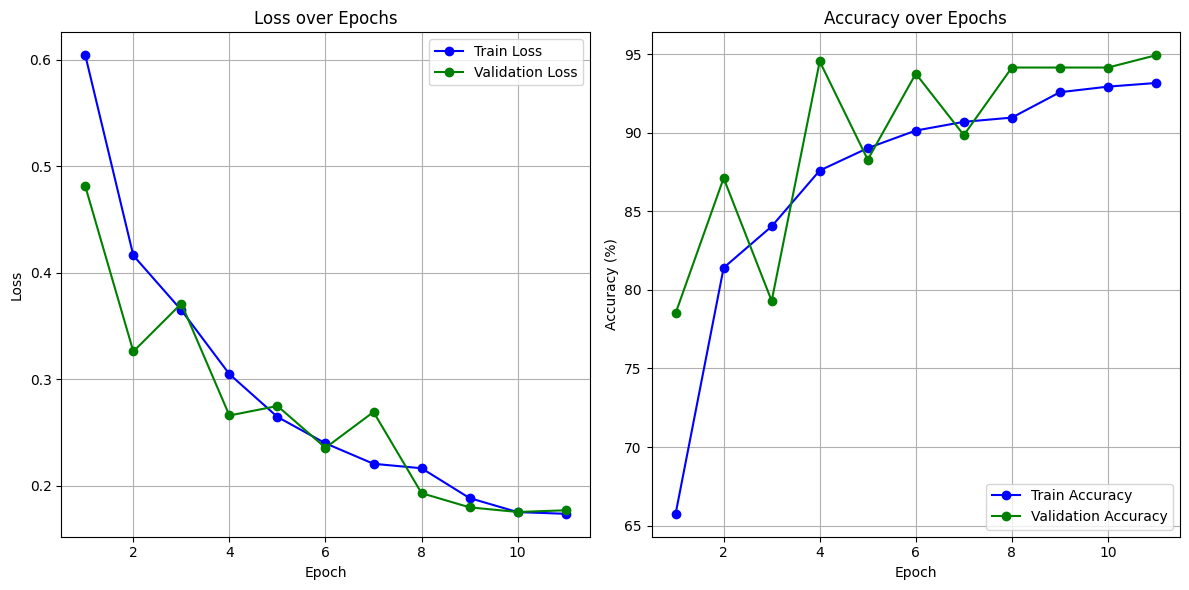

In [360]:
# Visualization of the loss and accuracy of train and validation dataset (per epoch)

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 6))

print(epochs_range, len(train_acc_list))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, label='Train Loss', color='blue', marker='o')
plt.plot(epochs_range, val_loss_list, label='Validation Loss', color='green', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_list, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs_range, val_acc_list, label='Validation Accuracy', color='green', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Part 5 - Apply on test and show model performance estimation

In [361]:
# conf matrix and report...
from sklearn.metrics import classification_report, confusion_matrix

all_model_preds = []
all_real_labels = []

model.eval()
with torch.inference_mode():
    for batch, labels in tqdm(test_loader):
        # Move data to device
        labels = labels.to(device)
        batch = batch.to(device)

        # Forward pass
        logits = model(batch)
        logits = logits.squeeze(dim=1)

        # Calculate accuracy
        y_pred = torch.round(torch.sigmoid(logits))

        # Save predictions and targets to lists:
        all_model_preds.extend(y_pred.cpu().numpy())
        all_real_labels.extend(labels.cpu().numpy())

100%|██████████| 4/4 [00:00<00:00, 17.08it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       100
           1       0.97      0.93      0.95       100

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200

Confusion Matrix (0: female, 1: male):
[[97  3]
 [ 7 93]]


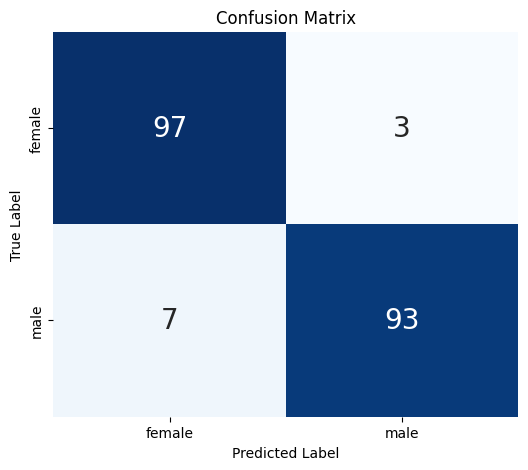

In [362]:
# Classification report:
report = classification_report(all_real_labels, all_model_preds)
print('Classification Report:')
print(report)

# Confusion matrix:
conf_matrix = confusion_matrix(all_real_labels, all_model_preds)
print('Confusion Matrix (0: female, 1: male):')
print(conf_matrix)

# Visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['female', 'male'], yticklabels=['female', 'male'], annot_kws={"size": 20})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

torch.Size([3, 128, 100])


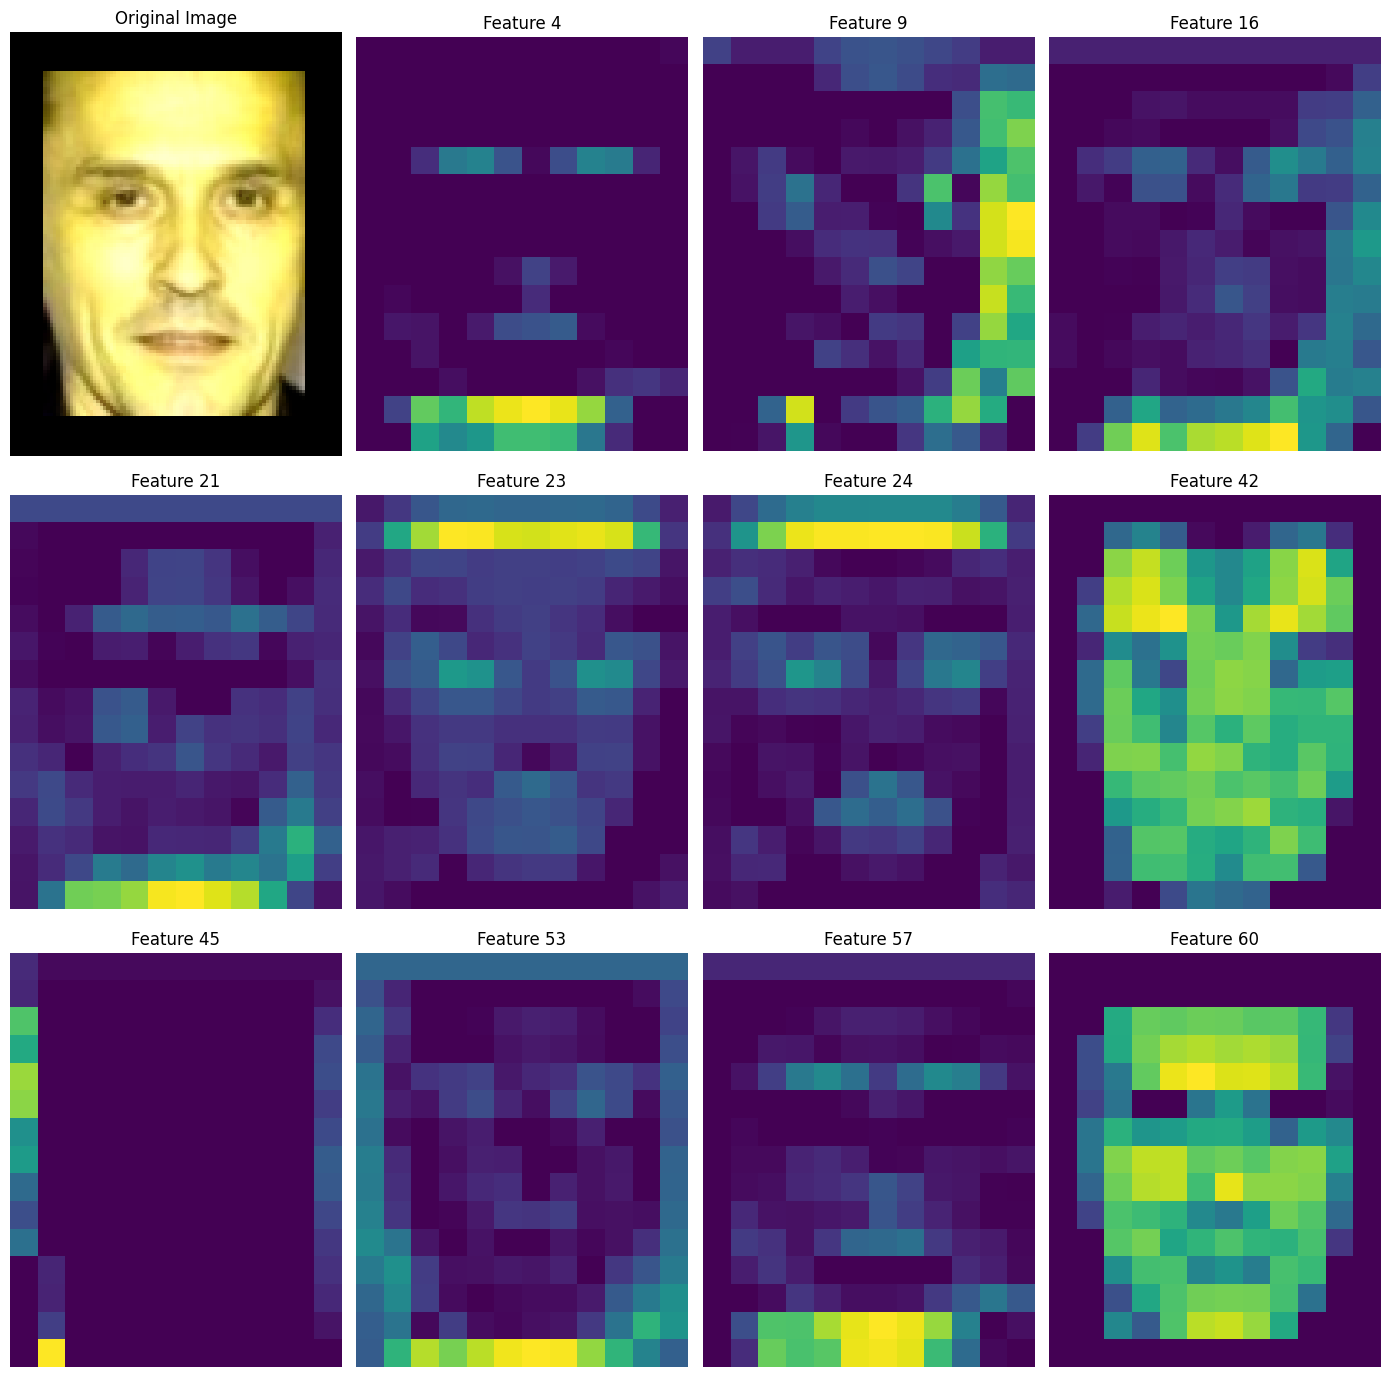

In [363]:
# Visualizing some features on an example image.
torch.manual_seed(RANDOM_SEED+92)

# Choose randim image from train dataset
random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
face_img, label = train_dataset[random_idx]
print(face_img.shape)

batch_of_one = face_img.unsqueeze(0) # [3 128, 100] -> [1, 3, 128, 100]
batch_of_one = batch_of_one.to(device)

# Get features tensor
model.eval()
with torch.inference_mode():
    features = model.test_conv_layers(batch_of_one)
    features = features.squeeze(0)


# Manually specify 11 feature indices
manual_indices = torch.tensor([4, 9, 16, 21, 23, 24, 42, 45, 53, 57, 60])
manal_features = features[manual_indices]  # shape [11, 3, 15, 12]

fig, axes = plt.subplots(3, 4, figsize=(14, 14))
axes = axes.flatten()

# Show original image
axes[0].imshow(face_img.permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Original Image")
axes[0].axis('off')


# Show 9 feature maps
for ax, feature_map, idx in zip(axes[1:], manal_features, manual_indices):
    ax.imshow(feature_map.cpu().numpy(), cmap='viridis')
    ax.set_title(f"Feature {idx.item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()

#ll

Hyperparameters Decisions:

1. Model Architecture:
The model architecture we started with had three conv layers and one fully connected layer.
The model didn't succeed in training and it got stuck in 50% accuracy of the train and validation.
We tried to add a fully connected layer and remove a conv layer and the model still couln't train well.
At the end we tried three conv layers and two fully connected layers and we got the best results so we went with it.

2. Optimizer:
We began with SGD (Stochastic Gradient Descent) and between epochs we had very small changes in loss and the accuracy barely changed, so we tried using Adam optimizer and the changes in loss and accuracy became much more efficient between epochs.

3. Transformations:
We added the transformations we named earlier for better handling by the model.

4. Number of Epochs:
We started with 10 epochs and we noticed that if we keep going the model might get better, so we tried 20 epochs and we saw that after 11 epochs we start to overfit so we finally changed the number of epochs to 11.